In [1]:
# Train and test an FCNN to map a contrast, Canny, tx (CCT) feature vector onto a visibility class
# Put these at the top of every notebook, to get automatic reloading and inline plotting
# Based on tf xfer learning tutorial at https://www.tensorflow.org/tutorials/images/transfer_learning
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# These are all the package we'll use
from fastai.imports import *
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pickle
from sklearn.model_selection import train_test_split

In [3]:
#check to make sure you have access to a GPU
# torch.cuda.is_available()
# torch.backends.cudnn.enabled
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [58]:
feat_vec, vis_class = None, None
with open('CCT/0716_QUEE_JFK_CCT_5cl.pickle', 'rb') as f:
    feat_vecs, vis_class = pickle.load(f), pickle.load(f)
num_classes = max(vis_class) + 1
print('Found %d datapoints belonging to %d classes.' % (len(vis_class), num_classes))

Found 12673 datapoints belonging to 5 classes.


In [59]:
[sum([1 if dp == cl else 0 for dp in vis_class]) for cl in range(num_classes)]

[267, 175, 391, 1059, 10781]

In [84]:
model = Sequential([
    tf.keras.Input(shape=len(feat_vecs[0])),
    layers.Dense(16, activation='elu'),
    layers.Dense(16, activation='elu'),
    layers.Dense(num_classes, activation = 'softmax')
])
#model.build((None, len(feat_vec[0])))

In [85]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 85        
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [86]:
x_train, x_val, y_train, y_val = train_test_split(feat_vecs, vis_class, train_size = 0.8)

In [87]:
base_learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #logits are raw model output, not probabilities
              metrics=['accuracy'])

In [88]:
class_wgt = {0: 40, 1: 62, 2: 28, 3: 10, 4: 1}
train_kwargs = dict(validation_data=(x_val, y_val), steps_per_epoch = 5, #train_gen.samples/train_gen.batch_size,
                    #validation_steps=5, #val_gen.samples/val_gen.batch_size,
                    #callbacks = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = .1**.333, patience = 100, verbose = 1, min_lr=1e-6),
                    class_weight=class_wgt)
epochs = 25
history = model.fit(
  x_train,
  y_train,
  epochs=epochs,
  **train_kwargs
)

Epoch 1/25
5/5 [==============================] - 1s 111ms/step - loss: 7.1606 - accuracy: 0.0148 - val_loss: 1.6846 - val_accuracy: 0.0103
Epoch 2/25
5/5 [==============================] - 0s 48ms/step - loss: 6.8777 - accuracy: 0.0143 - val_loss: 1.6302 - val_accuracy: 0.0103
Epoch 3/25
5/5 [==============================] - 0s 49ms/step - loss: 7.1615 - accuracy: 0.0169 - val_loss: 1.5908 - val_accuracy: 0.0134
Epoch 4/25
5/5 [==============================] - 0s 47ms/step - loss: 6.9343 - accuracy: 0.0838 - val_loss: 1.5561 - val_accuracy: 0.6402
Epoch 5/25
5/5 [==============================] - 0s 48ms/step - loss: 6.9042 - accuracy: 0.7386 - val_loss: 1.5279 - val_accuracy: 0.8481
Epoch 6/25
5/5 [==============================] - 0s 49ms/step - loss: 6.8893 - accuracy: 0.8462 - val_loss: 1.5047 - val_accuracy: 0.8493
Epoch 7/25
5/5 [==============================] - 0s 47ms/step - loss: 6.7555 - accuracy: 0.8496 - val_loss: 1.4866 - val_accuracy: 0.8473
Epoch 8/25
5/5 [==========

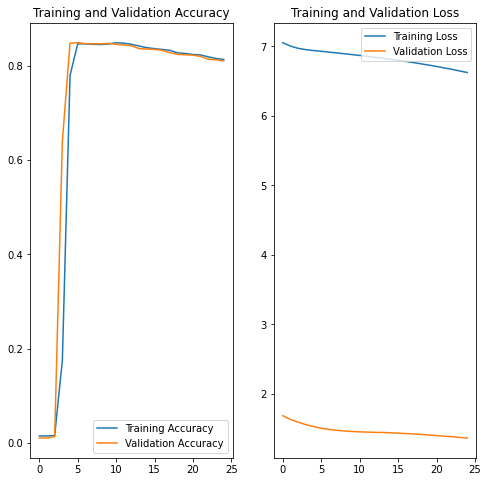

In [89]:
total_epochs = epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
val_preds = [np.argmax(out) for out in model.predict(x_val)]
diffs = [val_preds[i] - y_val[i] for i in range(len(y_val))]
sum([1 if diff else 0 for diff in diffs]) / len(diffs)

0.23550295857988165

In [67]:
np.argmax(model.predict([[.1, .02, .05]]))
sum([1 if pred == 1 else 0 for pred in val_preds])

71

# Visualize decision boundaries of the NN

In [106]:
#generate a grid of feature vectors
conts = np.linspace(0, 0.4, 30)
cannys = np.linspace(0, .15, 30)
txs = np.linspace(0, .7, 30)

CONTS, CANNYS, TXS = np.meshgrid(conts, cannys, txs)

# flatten each grid to a vector
r1, r2, r3 = CONTS.flatten(), CANNYS.flatten(), TXS.flatten()
r1, r2, r3 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1)), r3.reshape((len(r3), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2,r3))
yhat = np.array([np.argmax(out) for out in model.predict(grid)])
#print(yhat)

(8186,)
(5672,)
(5086,)
(1569,)
(6487,)


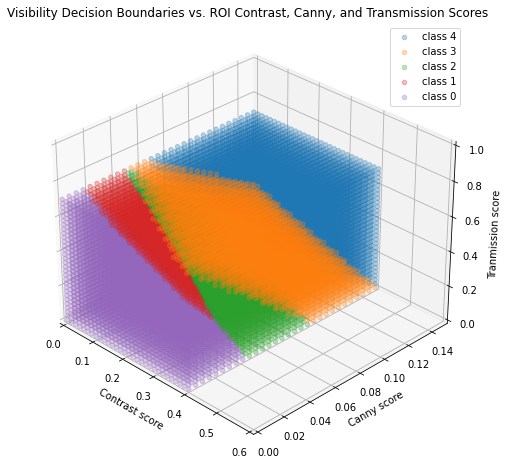

In [107]:
# reshape the predictions back into a grid
yhat = yhat.reshape(CONTS.shape)

plt.rcParams['figure.figsize'] = [20, 8]
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(num_classes - 1, -1, -1):
    selidxs = np.where(yhat == i)#[0]
    print(selidxs[1].shape)
    ax.scatter(conts[selidxs[0]], cannys[selidxs[1]], txs[selidxs[2]], label='class %d' % i, alpha = 0.3)

plt.legend()
plt.xlabel("Contrast score")
plt.ylabel("Canny score")
ax.set_zlabel("Tranmission score")
plt.title('Visibility Decision Boundaries vs. ROI Contrast, Canny, and Transmission Scores')
plt.xlim(0, 0.6)
plt.ylim(0, .15)
ax.set_zlim(0, 1)
ax.view_init(30, 315)

In [104]:
#additional epochs
epochs = 25
addl_history = model.fit(
  x_train,
  y_train,
  epochs=epochs,
  **train_kwargs
)
total_epochs += epochs

Epoch 1/25
5/5 [==============================] - 1s 188ms/step - loss: 5.9421 - accuracy: 0.7825 - val_loss: 1.0887 - val_accuracy: 0.7767
Epoch 2/25
5/5 [==============================] - 1s 170ms/step - loss: 5.9201 - accuracy: 0.7889 - val_loss: 1.0782 - val_accuracy: 0.7759
Epoch 3/25
5/5 [==============================] - 1s 171ms/step - loss: 5.8940 - accuracy: 0.7838 - val_loss: 1.0875 - val_accuracy: 0.7696
Epoch 4/25
5/5 [==============================] - 1s 170ms/step - loss: 5.8707 - accuracy: 0.7775 - val_loss: 1.0862 - val_accuracy: 0.7657
Epoch 5/25
5/5 [==============================] - 1s 165ms/step - loss: 5.8488 - accuracy: 0.7800 - val_loss: 1.0668 - val_accuracy: 0.7700
Epoch 6/25
5/5 [==============================] - 1s 172ms/step - loss: 5.8262 - accuracy: 0.7834 - val_loss: 1.0593 - val_accuracy: 0.7712
Epoch 7/25
5/5 [==============================] - 1s 172ms/step - loss: 5.8043 - accuracy: 0.7868 - val_loss: 1.0399 - val_accuracy: 0.7755
Epoch 8/25
5/5 [====

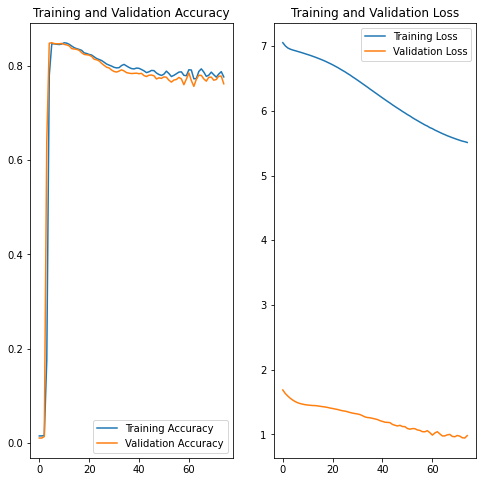

In [105]:
acc += addl_history.history['accuracy']
val_acc += addl_history.history['val_accuracy']

loss += addl_history.history['loss']
val_loss += addl_history.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Generate confusion matrices on testing data

In [108]:
feat_vec_test, vis_class_test = None, None
with open('CCT/0716_QUEE_JFK_CCT_test_5cl.pickle', 'rb') as f:
    feat_vec_test, vis_class_test = pickle.load(f), pickle.load(f)

In [109]:
test_preds = [np.argmax(out) for out in model.predict(feat_vec_test)]
test_diffs = [test_preds[i] - vis_class_test[i] for i in range(len(vis_class_test))]
print('Test accuracy: %f%%' % (100 * sum([0 if diff else 1 for diff in test_diffs]) / len(test_diffs)))

Test accuracy: 66.555805%


In [110]:
from sklearn.metrics import confusion_matrix as conf_mat

cmat = conf_mat(vis_class_test, test_preds)
cmat_pro = conf_mat(vis_class_test, test_preds, normalize = 'true') #confusion matrix of proportions

[[ 124   76   39   30   14]
 [  61   47   20   20   12]
 [ 122  181  132   66   31]
 [  46  185  301  265  184]
 [  13   77  647 2199 8037]]
[[0.43816254 0.26855124 0.13780919 0.10600707 0.04946996]
 [0.38125    0.29375    0.125      0.125      0.075     ]
 [0.22932331 0.34022556 0.2481203  0.12406015 0.05827068]
 [0.04689093 0.18858308 0.30682977 0.27013252 0.18756371]
 [0.00118473 0.00701722 0.05896291 0.20040098 0.73243416]]


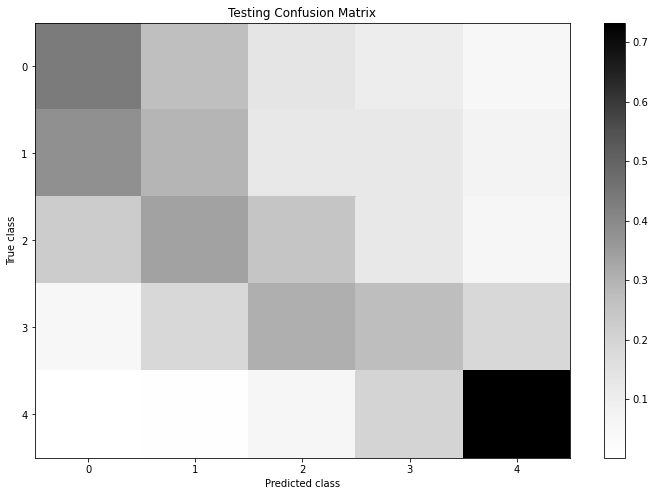

In [113]:
print(cmat)
print(cmat_pro)

plt.rcParams['figure.figsize'] = [12, 8]
plt.pcolormesh(cmat_pro, cmap = 'Greys')
plt.gca().invert_yaxis()
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Testing Confusion Matrix')

tick_args = (np.arange(0.5, num_classes + 0.5, 1), np.arange(0, num_classes, 1))
plt.xticks(*tick_args)
plt.yticks(*tick_args)
plt.colorbar()

In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score

score_kwargs = dict(y_true=vis_class_test, y_pred=test_preds, average='micro')
(recall_score(**score_kwargs), precision_score(**score_kwargs), f1_score(**score_kwargs))

(0.6655580477995204, 0.6655580477995204, 0.6655580477995204)